*数据预处理*

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import warnings
from itertools import combinations

# 忽略一些警告，保持输出整洁
warnings.filterwarnings('ignore')

# 1. 读取数据
file_path = 'cleaned_final_dataset2_2000_2025.parquet'
df = pd.read_parquet(file_path, engine='fastparquet')

selected_vars = [col for col in df.columns if col not in ['ts_code', 'year', 'month', 'next_ret']]
column_order = ['ts_code', 'year', 'month', 'next_ret'] + selected_vars

# 2. 直接重新排列
df = df[column_order]


In [2]:
df = df.rename(columns={'ts_code': 'stkcd'})

# 【关键修正】：先将年份和月份转换为整数 (int)，去掉 .0
# 这一步是为了防止出现 "2001.0-1.0-01" 这种错误格式
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df = df.drop(columns=['date', 'next_ret'], errors='ignore')

# 2. 构造时间索引
print("正在构造时间索引...")
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-01')

# ================= 修改开始 =================

# 步骤 A: 严格排序
# 必须先按 股票代码 和 日期 排序，否则 shift 会乱
df = df.sort_values(['stkcd', 'date']).reset_index(drop=True)

ret_col = 'ret' 

# 步骤 B: 构造“理论上的下个月日期”
# 使用 DateOffset 自动处理跨年问题（例如 12月+1个月 = 次年1月）
df['expected_next_date'] = df['date'] + pd.DateOffset(months=1)

# 步骤 C: 获取物理位置上的“下一行”数据
# 这一步和原来一样，先把下一行的数据拉上来
df['next_ret_raw'] = df.groupby('stkcd')[ret_col].shift(-1)
df['next_date_raw'] = df.groupby('stkcd')['date'].shift(-1)

# 步骤 D: 【核心修复】校验日期是否匹配
# 如果 "下一行的日期" == "理论上的下个月"，说明数据连续，保留收益率
# 否则，说明中间有停牌或断层，置为 NaN
import numpy as np
df['next_ret'] = np.where(
    df['next_date_raw'] == df['expected_next_date'], 
    df['next_ret_raw'], 
    np.nan
)

# 步骤 E: 清理中间变量，节省内存
df = df.drop(columns=['expected_next_date', 'next_ret_raw', 'next_date_raw'])
# ================= 修改结束 =================

df = df.dropna(subset=['next_ret']).copy()

df = df.sort_values(['date', 'stkcd']).reset_index(drop=True)

# 【新增】备份原始市值，用于后续加权
df['raw_size'] = df['size'] 

# 更新特征列表
feature_cols = [col for col in df.columns if col not in ['stkcd', 'year', 'month', 'ret', 'date', 'next_ret', 'raw_size']]
print(f"特征工程完成。总特征数量: {len(feature_cols)}")


# 6. 特征标准化：Rank Normalization (映射到 [-1, 1])
print("正在进行截面标准化...")
def rank_normalize(x):
    return (x.rank() - 1) / (x.count() - 1) * 2 - 1

df[feature_cols] = df.groupby('date')[feature_cols].transform(rank_normalize)
df[feature_cols] = df[feature_cols].fillna(0)

# === 【新增代码开始】 ===
# 构造截面排名目标 (Cross-Sectional Rank)
# 作用：将每一天所有股票的下期收益率，映射到 0~1 之间。
# 1.0 代表涨幅全场第一，0.0 代表跌幅全场第一。
print("正在构造截面排名目标 (Target Ranking)...")
df['rank_ret'] = df.groupby('date')['next_ret'].rank(pct=True, method='first')
# === 【新增代码结束】 ===

print("第一步完成：数据准备就绪。")
df


正在构造时间索引...
特征工程完成。总特征数量: 91
正在进行截面标准化...
正在构造截面排名目标 (Target Ranking)...
第一步完成：数据准备就绪。


,stkcd,year,month,ret,size,Bm,Ep,OCFtoNI,APTurnover,APDays,...,DividendYield,RVI_Strength,RankMomentum_6_1,RVI_Cross,RVI_Volume,Roe,date,next_ret,raw_size,rank_ret
0,000001.SZ,2000,1,NaN,0.993620,-0.472843,0.000000,0.000000,0.000000,0.000000,...,0.517949,1.000000,0.000000,0.760766,0.000000,0.000000,2000-01-01,-0.009730,2.870917e+06,0.124204
1,000002.SZ,2000,1,NaN,0.620415,0.667732,0.000000,0.000000,0.000000,0.000000,...,-0.641026,-0.110048,0.000000,-0.113238,0.000000,0.000000,2000-01-01,0.405687,5.755420e+05,0.945860
2,000003.SZ,2000,1,NaN,-0.837321,0.246006,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.110048,0.000000,-0.113238,0.000000,0.000000,2000-01-01,0.147826,1.917243e+05,0.689490
3,000005.SZ,2000,1,NaN,0.377990,0.175719,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.110048,0.000000,-0.113238,0.000000,0.000000,2000-01-01,0.040000,4.273644e+05,0.305732
4,000006.SZ,2000,1,NaN,-0.231260,0.795527,0.000000,0.000000,0.000000,0.000000,...,0.210256,-0.110048,0.000000,-0.113238,0.000000,0.000000,2000-01-01,0.049136,2.786972e+05,0.337580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544961,920839.BJ,2025,9,-0.025748,-0.805120,-0.787645,0.265329,0.091843,-0.294596,0.294596,...,0.000000,0.745114,-0.740895,0.846408,-0.013763,0.936580,2025-09-01,0.188095,5.007030e+05,0.954871
544962,920946.BJ,2025,9,-0.082988,-0.883843,-0.243795,0.272111,0.329305,0.620569,-0.620569,...,0.000000,0.802918,0.049208,0.846408,-0.013763,0.512458,2025-09-01,0.095023,4.717448e+05,0.878646
544963,920953.BJ,2025,9,-0.138155,-0.948803,-0.762272,-0.023453,-0.522659,0.726322,-0.726322,...,0.000000,-0.963666,-0.974423,-0.849711,-0.013763,0.678369,2025-09-01,0.293403,4.427689e+05,0.982664
544964,920978.BJ,2025,9,0.112385,-0.401046,-0.844457,0.203730,-0.216314,-0.205694,0.205694,...,0.000000,-0.006056,0.535724,-0.003303,-0.013763,0.950170,2025-09-01,0.076031,6.974745e+05,0.835718


*XGBoost预测*

In [3]:
# ==========================================
# 修改后的 Step 2: 使用 XGBoost (GPU版) + 滚动预测
# ==========================================

# 1. 设定参数
train_window_months = 24
unique_dates = sorted(df['date'].unique())

predictions = []
feature_importances = []

print(f"开始滚动预测 (使用 XGBoost GPU)... 总共有 {len(unique_dates)} 个月的数据。")

# 2. 滚动循环
for i in range(train_window_months, len(unique_dates)):
    predict_date = unique_dates[i]
    start_date = unique_dates[i - train_window_months]
    
    # 切分训练集和测试集
    train_mask = (df['date'] >= start_date) & (df['date'] < predict_date)
    test_mask = (df['date'] == predict_date)
    
    # 注意：这里使用我们之前构造的 'rank_ret' 作为训练目标
    # 如果你没做第一步修改，这里还是 'next_ret'，但强烈建议用 rank_ret
    X_train = df.loc[train_mask, feature_cols]
    y_train = df.loc[train_mask, 'rank_ret'] 
    
    X_test = df.loc[test_mask, feature_cols]
    
    if len(X_train) == 0 or len(X_test) == 0:
        continue
        
    # 3. 模型训练 (XGBoost GPU 模式)
    # ------------------------------------------------------------------
    model = xgb.XGBRegressor(
        # --- 核心参数 ---
        n_estimators=1000,        # 树的数量，给多点，配合 early_stopping 
        max_depth=6,              # 树深，量化通常 4-6 足够，防过拟合
        learning_rate=0.05,       # 学习率，越低越稳，但需要更多树
        
        # --- GPU 加速关键参数 ---
        # 旧版 xgboost 请用: tree_method='gpu_hist'
        # 新版 xgboost (2.0+) 推荐: device='cuda'
        tree_method='hist',       
        device='cuda',            
        
        # --- 训练目标 ---
        # 预测排名(0~1)本质是回归问题，用平方误差即可
        # 也可以尝试 objective='rank:pairwise' (需要特殊数据格式，暂不展开)
        objective='reg:squarederror', 
        
        # --- 正则化 (防止过拟合) ---
        subsample=0.8,            # 每次只用 80% 的样本
        colsample_bytree=0.8,     # 每次只用 80% 的特征
        reg_alpha=0.1,            # L1 正则
        reg_lambda=1.0,           # L2 正则
        
        n_jobs=-1,
        random_state=42
    )
    # ------------------------------------------------------------------
    
    model.fit(X_train, y_train)
    
    # 4. 预测
    pred_y = model.predict(X_test)
    
    # 5. 存储结果
    temp_res = df.loc[test_mask, ['date', 'stkcd', 'next_ret', 'raw_size']].copy()
    temp_res['pred_ret'] = pred_y
    predictions.append(temp_res)
    
    # 记录特征重要性 (XGBoost 的 feature_importances_ 依然可用)
    if i % 12 == 0: 
        feature_importances.append({
            'date': predict_date,
            'importance': model.feature_importances_
        })
    
    print(f"已完成预测: {predict_date.date()}")

all_predictions = pd.concat(predictions)
print("第二步完成：XGBoost 预测生成完毕。")

开始滚动预测 (使用 XGBoost GPU)... 总共有 309 个月的数据。
已完成预测: 2002-01-01
已完成预测: 2002-02-01
已完成预测: 2002-03-01
已完成预测: 2002-04-01
已完成预测: 2002-05-01
已完成预测: 2002-06-01
已完成预测: 2002-07-01
已完成预测: 2002-08-01
已完成预测: 2002-09-01
已完成预测: 2002-10-01
已完成预测: 2002-11-01
已完成预测: 2002-12-01
已完成预测: 2003-01-01
已完成预测: 2003-02-01
已完成预测: 2003-03-01
已完成预测: 2003-04-01
已完成预测: 2003-05-01
已完成预测: 2003-06-01
已完成预测: 2003-07-01
已完成预测: 2003-08-01
已完成预测: 2003-09-01
已完成预测: 2003-10-01
已完成预测: 2003-11-01
已完成预测: 2003-12-01
已完成预测: 2004-01-01
已完成预测: 2004-02-01
已完成预测: 2004-03-01
已完成预测: 2004-04-01
已完成预测: 2004-05-01
已完成预测: 2004-06-01
已完成预测: 2004-07-01
已完成预测: 2004-08-01
已完成预测: 2004-09-01
已完成预测: 2004-10-01
已完成预测: 2004-11-01
已完成预测: 2004-12-01
已完成预测: 2005-01-01
已完成预测: 2005-02-01
已完成预测: 2005-03-01
已完成预测: 2005-04-01
已完成预测: 2005-05-01
已完成预测: 2005-06-01
已完成预测: 2005-07-01
已完成预测: 2005-08-01
已完成预测: 2005-09-01
已完成预测: 2005-10-01
已完成预测: 2005-11-01
已完成预测: 2005-12-01
已完成预测: 2006-01-01
已完成预测: 2006-02-01
已完成预测: 2006-03-01
已完成预测: 2006-04-01
已完成预测: 2006-05-01
已完成预

In [38]:
all_predictions.to_parquet('predictions_XGBoost.parquet', index=False)

# 如果需要保存索引
all_predictions.to_parquet('predictions_XGBoost_with_index.parquet', index=True)

*IC分析*

Information Coefficient (IC) Mean: 0.1150
IC IR (IC / IC_Std): 1.0543


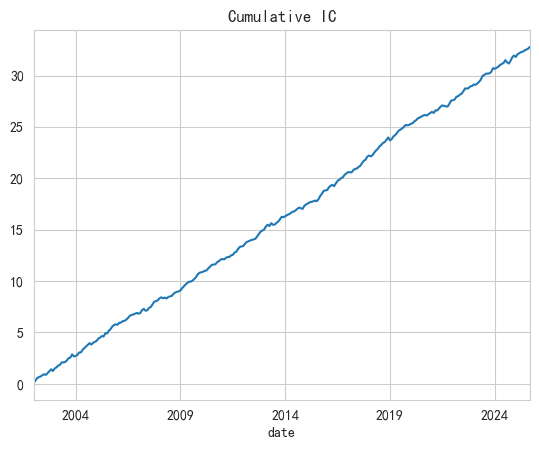

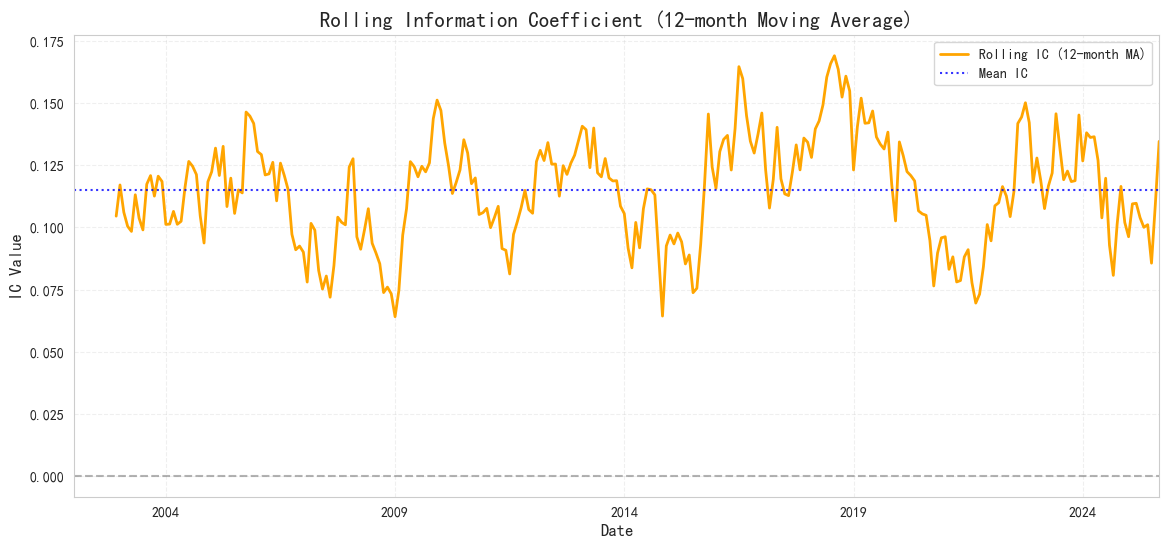

In [41]:
# 计算 Rank IC (Spearman Correlation)
# 对每个时间截面，计算 pred_ret 和 next_ret 的相关性
ic_series = all_predictions.groupby('date').apply(
    lambda x: x['pred_ret'].corr(x['next_ret'], method='spearman')
)

print(f"Information Coefficient (IC) Mean: {ic_series.mean():.4f}")
print(f"IC IR (IC / IC_Std): {ic_series.mean() / ic_series.std():.4f}")

# 可以画一个 IC 的累积图
(ic_series.cumsum()).plot(title="Cumulative IC")

# ==========================================
# 补充：绘制滚动 IC (Rolling IC)
# ==========================================
import matplotlib.pyplot as plt

# 1. 设置滚动窗口大小 (例如 12 个月)
window_size = 12 

# 2. 计算滚动平均 IC
rolling_ic = ic_series.rolling(window=window_size).mean()

# 3. 绘图
plt.figure(figsize=(14, 6))

# 绘制滚动 IC 曲线
rolling_ic.plot(label=f'Rolling IC ({window_size}-month MA)', color='orange', linewidth=2)

# 添加辅助线和标签
plt.axhline(y=0, color='grey', linestyle='--', alpha=0.6)  # 0轴参考线
plt.axhline(y=ic_series.mean(), color='blue', linestyle=':', label='Mean IC', alpha=0.8) # 全局均值参考线

plt.title(f'Rolling Information Coefficient ({window_size}-month Moving Average)', fontsize=15)
plt.ylabel('IC Value', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()
ic_series.to_csv('ic_series_boost.csv')

*Barra检验*

In [40]:
# ==========================================
# 最终修复版：Barra + 行业中性化 截面回归
# ==========================================
import statsmodels.api as sm
from scipy import stats
import pandas as pd
import numpy as np

print(f"{'='*20} 开始 Barra 截面回归检验 (Final Fix) {'='*20}")

# 1. 读取数据
df_industry = pd.read_parquet('stock_basic.parquet', engine='fastparquet')
df_industry = df_industry.rename(columns={'ts_code': 'stkcd'})

df_barra = pd.read_csv('全A股月度cne5数据_2007-2025.csv')
# 日期强制对齐到月末
df_barra['date'] = pd.to_datetime(df_barra['date']) + pd.offsets.MonthEnd(0)
all_predictions['date'] = pd.to_datetime(all_predictions['date']) + pd.offsets.MonthEnd(0)

# 2. 数据准备 (白名单机制)
# Industry 表
df_industry_clean = df_industry[['stkcd', 'industry']]

# Barra 表 (明确指定因子)
style_factors = [
    'size', 'beta', 'momentum', 'residual_volatility', 'non_linear_size',
    'book_to_price_ratio', 'liquidity', 'earnings_yield', 'growth', 'leverage'
]
# 确保列名存在
valid_style_factors = [c for c in style_factors if c in df_barra.columns]
df_barra_clean = df_barra[['date', 'stkcd'] + valid_style_factors]

# 3. 安全合并
print("正在合并数据...")
barra_data = pd.merge(
    all_predictions[['date', 'stkcd', 'pred_ret', 'next_ret']],
    df_barra_clean,
    on=['date', 'stkcd'],
    how='inner'
)
barra_data = pd.merge(barra_data, df_industry_clean, on='stkcd', how='left')

# 检查数据量
if len(barra_data) == 0:
    raise ValueError("合并后数据为空！请检查日期或代码格式。")

# 4. 生成行业哑变量 (关键修复：dtype=int)
print("正在生成行业哑变量 (强制数值化)...")
barra_data['industry'] = barra_data['industry'].fillna('Unknown')
# 【修复点】指定 dtype=int，保证生成的是 0/1 而不是 True/False
barra_data = pd.get_dummies(barra_data, columns=['industry'], prefix='IND', drop_first=True, dtype=int)

# 5. 定义回归自变量 X
# 自动收集所有行业列
industry_cols = [c for c in barra_data.columns if c.startswith('IND_')]
# 最终 X = 预测分 + 风格因子 + 行业哑变量
X_columns = ['pred_ret'] + valid_style_factors + industry_cols

# 再次确保所有 X 都是数值型 (双重保险)
# 将所有 X 列强制转为 float，无法转换的变为 NaN
for col in X_columns:
    barra_data[col] = pd.to_numeric(barra_data[col], errors='coerce')

# 6. 定义回归函数
def cross_sectional_regression_safe(group):
    # 提取当期数据
    # subset 包含 Y 和所有 X
    data = group.dropna(subset=['next_ret'] + X_columns)
    
    # 样本量检查 (因为因子很多，样本少会导致奇异矩阵)
    if len(data) < len(X_columns) + 10:
        return None
    
    Y = data['next_ret']
    X = data[X_columns]
    X = sm.add_constant(X)
    
    try:
        model = sm.OLS(Y, X).fit()
        return model.params
    except:
        return None

# 7. 逐月回归
print(f"正在逐月回归 (因子总数: {len(X_columns)})...")
monthly_gammas = barra_data.groupby('date').apply(cross_sectional_regression_safe)

# 8. 统计检验与展示
barra_summary = pd.DataFrame({
    'Factor': monthly_gammas.columns,
    'Gamma_Mean': monthly_gammas.mean(),
    'T-Statistic': float('nan')
})

# 计算 T 值
for col in monthly_gammas.columns:
    series = monthly_gammas[col].dropna()
    if len(series) > 10:
        t_stat, _ = stats.ttest_1samp(series, 0)
        barra_summary.loc[barra_summary['Factor']==col, 'T-Statistic'] = t_stat

# 结果筛选展示 (只看核心因子)
show_list = ['const', 'pred_ret'] + valid_style_factors
display_df = barra_summary[barra_summary['Factor'].isin(show_list)]

print("\n>>> Barra + 行业中性化 回归结果:")
pd.options.display.float_format = '{:.4f}'.format
from IPython.display import display
display(display_df)

# 9. 最终结论
if 'pred_ret' in barra_summary['Factor'].values:
    ml_t = barra_summary.loc[barra_summary['Factor']=='pred_ret', 'T-Statistic'].values[0]
    print(f"\n>>> 核心结论: 控制行业和Barra风格后，ML因子的 t值为 {ml_t:.2f}")
    if abs(ml_t) > 1.96:
        print("   [显著] 完美！策略拥有纯粹的选股 Alpha。")
    else:
        print("   [不显著] 策略收益主要来源于风格暴露或行业轮动。")
else:
    print("错误：回归结果中依然没有 pred_ret，可能因为样本不足导致回归全部失败。")

==================== 开始 Barra 截面回归检验 (Final Fix) ====================
正在合并数据...
正在生成行业哑变量 (强制数值化)...
正在逐月回归 (因子总数: 121)...

>>> Barra + 行业中性化 回归结果:


,Factor,Gamma_Mean,T-Statistic
const,const,-0.0459,-6.8866
pred_ret,pred_ret,0.1270,15.1126
size,size,-0.0157,-9.7952
beta,beta,0.0018,2.1716
momentum,momentum,0.0014,1.9207
residual_volatility,residual_volatility,-0.0004,-0.5269
non_linear_size,non_linear_size,-0.0100,-10.3199
book_to_price_ratio,book_to_price_ratio,-0.0000,-0.0396
liquidity,liquidity,-0.0061,-5.7262
earnings_yield,earnings_yield,0.0023,3.6815



>>> 核心结论: 控制行业和Barra风格后，ML因子的 t值为 15.11
   [显著] 完美！策略拥有纯粹的选股 Alpha。


*Fama-Macbeth检验*

In [33]:
# ==========================================
# 新增模块: Fama-MacBeth 回归检验
# ==========================================
import statsmodels.api as sm

print(f"{'='*20} 开始 Fama-MacBeth 截面回归检验 {'='*20}")

# 1. 准备数据
# 我们需要把预测结果 (all_predictions) 和原始特征 (df) 合并
# 这样才能在回归中控制 Size, Bm 等变量
fmb_data = pd.merge(
    all_predictions[['date', 'stkcd', 'pred_ret', 'next_ret']], # 预测值和目标值
    df[['date', 'stkcd', 'size', 'Bm', 'MOM12', 'ILLIQ']],      # 控制变量(根据你df中存在的列名调整)
    on=['date', 'stkcd'],
    how='inner'
)

# 2. 定义每一期的截面回归函数
def cross_sectional_reg(group):
    # 去除空值
    group = group.dropna()
    
    if len(group) < 30: # 样本太少不回归
        return pd.Series(dtype=float)
    
    # Y = 下期收益
    Y = group['next_ret']
    
    # X = 随机森林预测分 + 控制变量
    # 核心是看 'pred_ret' 的系数是否显著
    X = group[['pred_ret', 'size', 'Bm', 'MOM12', 'ILLIQ']] 
    X = sm.add_constant(X)
    
    try:
        model = sm.OLS(Y, X).fit()
        return model.params
    except Exception as e:
        print(f"回归出错: {e}")
        return pd.Series(dtype=float)

# 3. 按月滚动执行回归
# lambdas 是每一期回归得到的系数序列
lambdas = fmb_data.groupby('date').apply(cross_sectional_reg)

# 4. 计算 Fama-MacBeth 统计量 (时序平均 + t检验)
fmb_summary = pd.DataFrame({
    'Mean_Coeff': lambdas.mean(),
    'Std_Error': lambdas.std() / np.sqrt(len(lambdas)),
    't-stat': lambdas.mean() / (lambdas.std() / np.sqrt(len(lambdas)))
})

print(">>> Fama-MacBeth 回归结果 (关注 pred_ret 的 t-stat):")
# 重点看 pred_ret 这一行的 t-stat 是否 > 1.96 (或 3.0)
print(fmb_summary)

# 简单判定
pred_t = fmb_summary.loc['pred_ret', 't-stat']
if pred_t > 1.96:
    print(f"\n[结论] 随机森林预测分子的 t值为 {pred_t:.2f}，显著正向，因子有效！")
else:
    print(f"\n[结论] 随机森林预测分子的 t值为 {pred_t:.2f}，统计上不显著。")

==================== 开始 Fama-MacBeth 截面回归检验 ====================
>>> Fama-MacBeth 回归结果 (关注 pred_ret 的 t-stat):
          Mean_Coeff  Std_Error     t-stat
const      -0.054372   0.006429  -8.456592
pred_ret    0.136332   0.007485  18.215212
size       -0.008149   0.001681  -4.849241
Bm          0.001293   0.001749   0.739289
MOM12       0.001458   0.001320   1.104937
ILLIQ       0.000209   0.000907   0.229995

[结论] 随机森林预测分子的 t值为 18.22，显著正向，因子有效！


*分组测试*

In [34]:
# ==========================================
# 修改后的 Step 3: 同时计算等权(EW)与加权(VW)
# ==========================================

# 1. 定义分组函数
def assign_group(x):
    # 如果该月数据太少（少于5个），直接返回 NaN
    if len(x) < 5:
        return np.nan
    
    # 关键步骤：使用 rank(method='first') 处理重复值
    # 这会将相同的值赋予不同的排名，从而保证 qcut 永远不会报错
    # pct=True 不是必须的，但 rank 之后数值变为 1...N，可以直接切分
    try:
        # 先排名，再切分
        return pd.qcut(x.rank(method='first'), q=5, labels=False)
    except Exception as e:
        # 如果还是报错，打印出来看看是什么问题
        print(f"Groupby Error: {e}")
        return np.nan

# 2. 对每个月应用分组
all_predictions['group'] = all_predictions.groupby('date')['pred_ret'].transform(assign_group)

# --- A. 计算等权收益 (Equal-Weighted) ---
port_returns_ew = all_predictions.groupby(['date', 'group'])['next_ret'].mean().unstack()
strategy_ew = port_returns_ew[4.0] - port_returns_ew[0.0]

# --- B. 计算市值加权收益 (Value-Weighted) ---
def weighted_avg_ret(group_df):
    if group_df['raw_size'].sum() == 0: # 防止除以0
        return group_df['next_ret'].mean()
    return np.average(group_df['next_ret'], weights=group_df['raw_size'])

port_returns_vw = all_predictions.groupby(['date', 'group']).apply(weighted_avg_ret).unstack()
strategy_vw = port_returns_vw[4.0] - port_returns_vw[0.0]

# 请保留这个完整的 DataFrame 供 GRS 使用：
port_returns_vw_full = all_predictions.groupby(['date', 'group']).apply(weighted_avg_ret).unstack()
# 确保列名是 0, 1, 2, 3, 4
port_returns_vw_full.columns = [0, 1, 2, 3, 4]
from pandas.tseries.offsets import MonthEnd
port_returns_vw_full.index = pd.to_datetime(port_returns_vw_full.index) + MonthEnd(0)

# --- C. 合并所有结果到一个 DataFrame ---
performance_df = pd.DataFrame({
    # 等权组
    'EW_Long': port_returns_ew[4.0],
    'EW_Short': port_returns_ew[0.0],
    'EW_Strategy': strategy_ew,
    
    # 加权组
    'VW_Long': port_returns_vw[4.0],
    'VW_Short': port_returns_vw[0.0],
    'VW_Strategy': strategy_vw
})

print("第三步完成：双重加权逻辑计算完毕。")
print(performance_df.head())
performance_df

第三步完成：双重加权逻辑计算完毕。
             EW_Long  EW_Short  EW_Strategy   VW_Long  VW_Short  VW_Strategy
date                                                                        
2002-01-01  0.035495  0.028573     0.006922  0.023008  0.020244     0.002764
2002-02-01  0.095903  0.056009     0.039894  0.080349  0.045584     0.034765
2002-03-01  0.069187  0.020481     0.048706  0.058869  0.029753     0.029116
2002-04-01 -0.081852 -0.098009     0.016156 -0.083617 -0.094861     0.011244
2002-05-01  0.134747  0.117739     0.017008  0.157561  0.124181     0.033380


,EW_Long,EW_Short,EW_Strategy,VW_Long,VW_Short,VW_Strategy
date,,,,,,
2002-01-01,0.035495,0.028573,0.006922,0.023008,0.020244,0.002764
2002-02-01,0.095903,0.056009,0.039894,0.080349,0.045584,0.034765
2002-03-01,0.069187,0.020481,0.048706,0.058869,0.029753,0.029116
2002-04-01,-0.081852,-0.098009,0.016156,-0.083617,-0.094861,0.011244
2002-05-01,0.134747,0.117739,0.017008,0.157561,0.124181,0.033380
...,...,...,...,...,...,...
2025-05-01,0.043020,0.048276,-0.005256,0.010594,0.049789,-0.039195
2025-06-01,0.083407,0.049042,0.034366,0.040889,0.051548,-0.010659
2025-07-01,0.123595,0.109526,0.014069,0.371437,0.095855,0.275583


In [39]:
performance_df.to_parquet('performance.parquet', index=False)

# 如果需要保存索引
performance_df.to_parquet('performance_with_index.parquet', index=True)

*统计指标*

In [28]:
# ==========================================
# Step 4: 完善统计指标 (Detailed Statistics)
# ==========================================
from scipy import stats

def get_summary_stats(returns):
    """
    输入: 月度收益率序列 (Series)
    输出: 包含各项统计指标的 Series
    """
    # 1. 基础数据
    num_months = len(returns)
    avg_ret = returns.mean()
    std_dev = returns.std()
    
    # 2. 年化指标 (假设是月度数据)
    # 年化收益率 = 月均收益 * 12
    ann_ret = avg_ret * 12
    # 年化波动率 = 月度波动率 * sqrt(12)
    ann_std = std_dev * np.sqrt(12)
    
    # 3. 夏普比率 (Sharpe Ratio)
    # 假设无风险利率 Rf 为 0，如果有具体Rf数据，应先减去 Rf
    if ann_std == 0:
        sharpe = 0
    else:
        sharpe = ann_ret / ann_std
        
    # 4. 最大回撤 (Max Drawdown)
    cum_ret = (1 + returns).cumprod()
    max_dd = ((cum_ret.cummax() - cum_ret) / cum_ret.cummax()).max()
    
    # 5. t-statistics (t统计量)
    # 检验收益率均值是否显著不为0
    t_stat, p_val = stats.ttest_1samp(returns, 0)
    
    # 6. 胜率 (Win Rate)
    win_rate = len(returns[returns > 0]) / num_months
    
    return pd.Series({
        'Avg Return (Monthly)': f"{avg_ret:.2%}",  # 月均收益
        'Ann Return': f"{ann_ret:.2%}",            # 年化收益
        'Ann Std Dev': f"{ann_std:.2%}",           # 年化波动率
        'Sharpe Ratio': f"{sharpe:.4f}",           # 夏普比率
        't-statistic': f"{t_stat:.4f}",            # t统计量 (关键!)
        'Max Drawdown': f"{max_dd:.2%}",           # 最大回撤
        'Win Rate': f"{win_rate:.2%}",             # 胜率
        'Obs (Months)': num_months                 # 观测月数
    })

# --- 执行计算 ---
print(f"{'='*20} 策略表现统计表 (Performance Summary) {'='*20}")

# 对 performance_df 中的每一列（即每一个策略/组合）应用上述函数
# 结果转置(.T)后，行是策略名，列是指标名，符合论文格式
summary_table = performance_df.apply(get_summary_stats).T

# 展示表格
from IPython.display import display
display(summary_table)

==================== 策略表现统计表 (Performance Summary) ====================


,Avg Return (Monthly),Ann Return,Ann Std Dev,Sharpe Ratio,t-statistic,Max Drawdown,Win Rate,Obs (Months)
EW_Long,2.94%,35.27%,31.17%,1.1317,5.5152,65.04%,63.16%,285
EW_Short,-0.03%,-0.38%,31.36%,-0.0121,-0.0589,90.47%,49.12%,285
EW_Strategy,2.97%,35.65%,11.79%,3.0248,14.7408,12.41%,84.56%,285
VW_Long,1.85%,22.17%,29.61%,0.7488,3.6492,74.68%,60.70%,285
VW_Short,-0.24%,-2.88%,27.45%,-0.1051,-0.5123,91.70%,47.37%,285
VW_Strategy,2.09%,25.06%,19.40%,1.2917,6.2947,23.08%,68.77%,285
VW_Long_Timing,1.44%,17.32%,24.24%,0.7142,3.4806,39.42%,30.53%,285
EW_Long_Timing,2.14%,25.67%,23.67%,1.0844,5.2849,35.82%,32.98%,285


*市场基准数据*

In [5]:
# ==========================================\n
# 新增步骤: 读取并处理市场基准指数数据
# ==========================================\n

# 1. 读取 Parquet 文件
# 确保环境支持 parquet (pip install pyarrow 或 fastparquet)
try:
    bench_df = pd.read_parquet('index_monthly_filtered.parquet', engine='fastparquet')
except Exception as e:
    print(f"读取 Parquet 失败，请检查是否安装 pyarrow: {e}")
    # 如果读取失败，可以用以下代码模拟空数据以防报错
    bench_df = pd.DataFrame(columns=['ts_code', 'year', 'month', 'pct_chg'])

if not bench_df.empty:
    # 2. 构造日期索引 (设为月初，与你的策略数据 date 格式对齐)
    bench_df['date'] = pd.to_datetime(
        bench_df['year'].astype(str) + '-' + bench_df['month'].astype(str) + '-01'
    )

    # 3. 数据透视: 行=日期, 列=指数代码, 值=收益率
    bench_pivoted = bench_df.pivot(index='date', columns='ts_code', values='pct_chg')

    # 4. 处理收益率单位
    # 指数数据通常是百分比(如 5.0 代表 5%)，而你的策略收益是小数(0.05)
    # 我们检查一下最大值，如果大于 1，则除以 100
    if bench_pivoted.max().max() > 1:
        bench_pivoted = bench_pivoted / 100.0

    # 5. 重命名列 (根据常见代码映射)
    index_map = {
        '000300.SH': '沪深300',
        '000905.SH': '中证500',
        '000001.SH': '上证指数'
    }
    bench_pivoted = bench_pivoted.rename(columns=index_map)
    
    # 只保留我们关心的这三个指数
    valid_indices = [c for c in bench_pivoted.columns if c in index_map.values()]
    bench_returns = bench_pivoted[valid_indices]

    # 6. 时间对齐与累计收益计算
    # 获取策略的起止时间
    start_date = performance_df.index[0]
    end_date = performance_df.index[-1]

    # 截取同时间段的指数数据 (自动处理"指数05年才有"的问题，05年之前会是 NaN)
    bench_returns = bench_returns.loc[(bench_returns.index >= start_date) & (bench_returns.index <= end_date)]

    # 计算累计净值 (自动从每个指数有数据的第一个点开始计算)
    # (1+r).cumprod() 会让起始点为 1+r1。为了图表好看，它们会自然从 1.0 附近开始增长。
    cum_bench = (1 + bench_returns).cumprod()
    
    print("基准指数数据处理完成。包含指数:", cum_bench.columns.tolist())
    print(cum_bench.head())

else:
    cum_bench = pd.DataFrame()
    print("警告：未加载到基准数据。")

基准指数数据处理完成。包含指数: ['上证指数', '沪深300', '中证500']
ts_code         上证指数     沪深300  中证500
date                                 
2002-01-01  0.906300  1.000000    NaN
2002-02-01  0.926329  1.018700    NaN
2002-03-01  0.974406  1.075034    NaN
2002-04-01  1.013187  1.107930    NaN
2002-05-01  0.920784  1.013756    NaN


*CH-3检验*

In [29]:
# ==========================================
# Step 5: CH-3 因子模型回归检验 (修正版)
# ==========================================
import statsmodels.api as sm
import pandas as pd

# 1. 读取因子数据

# 优先尝试读取 Excel
factors_df = pd.read_excel('CH3_factors_monthly.xlsx')

# 2. 数据清洗与对齐
print("因子原始列名:", factors_df.columns.tolist())

# 重命名列 (确保与你的文件表头一致)
rename_dict = {
    'mnthdt': 'date',      # 日期列
    'mktrf': 'MKT',        # 市场因子
    'SMB': 'SMB',          # 规模因子
    'VMG': 'VMG'           # 价值因子 (CH-3模型特有)
}
factors_df = factors_df.rename(columns=rename_dict)

# 处理因子数据的日期 -> 转为 datetime 并设为索引
factors_df['date'] = pd.to_datetime(factors_df['date'].astype(str))
factors_df = factors_df.set_index('date')
# 确保因子数据是月末日期
factors_df.index = factors_df.index + pd.offsets.MonthEnd(0)

# 【核心修复步骤】
# 将策略收益率的日期也调整为"月末"，以匹配因子数据
# 这样 2002-01-01 就会变成 2002-01-31，从而能匹配上
performance_df.index = pd.to_datetime(performance_df.index) + pd.offsets.MonthEnd(0)

# 3. 合并数据
# join='inner' 会自动取时间交集
aligned_data = pd.concat([performance_df, factors_df], axis=1, join='inner')

print(f"合并后数据量: {len(aligned_data)} 行 (如果为0说明日期仍未对齐)")
# 检查前几行看看是否正常
print(aligned_data[['EW_Strategy', 'MKT']].head())

# 4. 定义回归函数
def run_factor_regression(y_col, X_cols=['MKT', 'SMB', 'VMG']):
    # 确保没有空值
    data = aligned_data.dropna(subset=[y_col] + X_cols)
    
    Y = data[y_col]
    X = data[X_cols]
    X = sm.add_constant(X) # 添加 Alpha (截距项)
    
    model = sm.OLS(Y, X).fit()
    
    # 提取关键结果
    alpha = model.params['const']
    t_alpha = model.tvalues['const']
    
    return pd.Series({
        'Alpha (Monthly)': alpha,
        'Alpha (Annualized)': alpha * 12, # 年化Alpha
        't-stat (Alpha)': t_alpha,
        'Beta_MKT': model.params['MKT'],
        'Beta_SMB': model.params['SMB'],
        'Beta_VMG': model.params['VMG'],
        'R-squared': model.rsquared
    })

# 5. 执行检验
if not aligned_data.empty:
    print(f"\n{'='*20} CH-3 因子模型回归结果 {'='*20}")
    factor_results = pd.DataFrame({
        'EW_Strategy': run_factor_regression('EW_Strategy'),
        'VW_Strategy': run_factor_regression('VW_Strategy')
    })

    # 展示结果
    from IPython.display import display
    display(factor_results.T)

    # 6. 结果解读
    print("\n>>> 结果解读:")
    vw_t = factor_results.loc['t-stat (Alpha)', 'VW_Strategy']
    if vw_t > 1.96:
        print(f"市值加权策略的 Alpha t值 ({vw_t:.2f}) 显著大于 1.96，说明策略战胜了 CH-3 模型！")
    else:
        print(f"市值加权策略的 Alpha t值 ({vw_t:.2f}) 未超过 1.96，超额收益统计上不显著。")
else:
    print("错误：数据合并失败，请检查 performance_df 的索引格式。")

因子原始列名: ['mnthdt', 'rf_mon', 'mktrf', 'SMB', 'VMG']
合并后数据量: 285 行 (如果为0说明日期仍未对齐)
            EW_Strategy     MKT
date                           
2002-01-31     0.006922 -0.0993
2002-02-28     0.039894  0.0214
2002-03-31     0.048706  0.0553
2002-04-30     0.016156  0.0384
2002-05-31     0.017008 -0.0864

==================== CH-3 因子模型回归结果 ====================


,Alpha (Monthly),Alpha (Annualized),t-stat (Alpha),Beta_MKT,Beta_SMB,Beta_VMG,R-squared
EW_Strategy,0.029323,0.351873,13.443277,0.062711,0.077261,-0.043086,0.043387
VW_Strategy,0.019435,0.233222,5.355566,0.121219,0.005432,0.065502,0.022413



>>> 结果解读:
市值加权策略的 Alpha t值 (5.36) 显著大于 1.96，说明策略战胜了 CH-3 模型！


*CH-4检验*

In [30]:
# ==========================================
# Step 6: CH-4 四因子模型回归检验
# ==========================================
import statsmodels.api as sm
import pandas as pd

# 1. 读取数据

df_ch4 = pd.read_excel('CH4_factors_monthly.xlsx')

print("CH-4 原始列名:", df_ch4.columns.tolist())

# 2. 数据清洗与重命名 (关键：确认第4个因子的名字)
# 假设列名包含: mnthdt, mktrf, SMB, VMG, PMO (或 UMO)
rename_dict_4 = {
    'mnthdt': 'date',
    'mktrf': 'MKT',
    'SMB': 'SMB',
    'VMG': 'VMG', 
    'PMO': 'PMO' # 这里统一命名为 PMO
}
df_ch4 = df_ch4.rename(columns=rename_dict_4)

# 确保我们找到了第4个因子 (如果报错 KeyError，请检查上面打印的列名手动修改)

# 日期对齐 (强制转为月末)
df_ch4['date'] = pd.to_datetime(df_ch4['date'].astype(str))
df_ch4 = df_ch4.set_index('date')
df_ch4.index = df_ch4.index + pd.offsets.MonthEnd(0)

# 3. 合并数据 (Performance + CH4 Factors)
# 注意：performance_df 在上一步已经转为月末索引，这里可以直接合并
aligned_ch4 = pd.concat([performance_df, df_ch4], axis=1, join='inner')

# 4. 执行回归
def run_ch4_regression(y_col):
    # 自变量 X 包含 4 个因子
    X_cols = ['MKT', 'SMB', 'VMG', 'PMO']
    data = aligned_ch4.dropna(subset=[y_col] + X_cols)
    
    Y = data[y_col]
    X = sm.add_constant(data[X_cols]) # 截距项 Alpha
    
    model = sm.OLS(Y, X).fit()
    alpha = model.params['const']
    t_alpha = model.tvalues['const']
    
    return pd.Series({
        'Alpha (Monthly)': alpha,
        'Alpha (Ann.)': alpha * 12,
        't-stat (Alpha)': t_alpha,
        'Beta_MKT': model.params['MKT'],
        'Beta_SMB': model.params['SMB'],
        'Beta_VMG': model.params['VMG'],
        'Beta_PMO}': model.params['PMO'], 
        'R-squared': model.rsquared
    })

if not aligned_ch4.empty:
    print(f"\n{'='*20} CH-4 四因子回归结果 {'='*20}")
    ch4_results = pd.DataFrame({
        'EW_Strategy': run_ch4_regression('EW_Strategy'),
        'VW_Strategy': run_ch4_regression('VW_Strategy')
    })
    
    from IPython.display import display
    display(ch4_results.T)
    
    # 快速判断
    t_val = ch4_results.loc['t-stat (Alpha)', 'VW_Strategy']
    print(f"\n>>> 结论: 市值加权策略在 CH-4 模型下的 Alpha t值为 {t_val:.2f}")
    print("    (绝对值 > 1.96 表示即使在四因子模型下，超额收益依然显著)")
else:
    print("错误：数据合并为空，请检查日期格式。")

CH-4 原始列名: ['mnthdt', 'rf_mon', 'mktrf', 'VMG', 'SMB', 'PMO']

==================== CH-4 四因子回归结果 ====================


,Alpha (Monthly),Alpha (Ann.),t-stat (Alpha),Beta_MKT,Beta_SMB,Beta_VMG,Beta_PMO},R-squared
EW_Strategy,0.030417,0.365001,13.809455,0.049909,0.105123,-0.018677,-0.146947,0.066583
VW_Strategy,0.020893,0.250717,5.665743,0.104854,0.023143,0.074775,-0.176698,0.034068



>>> 结论: 市值加权策略在 CH-4 模型下的 Alpha t值为 5.67
    (绝对值 > 1.96 表示即使在四因子模型下，超额收益依然显著)


*GRS检验*

In [35]:
# ==========================================
# 新增模块: GRS 检验 (联合假设检验)
# ==========================================
from scipy.stats import f

def grs_test(factor_df, portfolio_df, factor_cols=['MKT', 'SMB', 'VMG']):
    """
    输入:
    factor_df: 包含因子收益率的 DataFrame (T x K)
    portfolio_df: 包含 5 个分组收益率的 DataFrame (T x N)
    """
    # 1. 数据对齐与准备
    # 确保只取两个表共有的日期
    common_index = factor_df.index.intersection(portfolio_df.index)
    f_data = factor_df.loc[common_index, factor_cols]
    r_data = portfolio_df.loc[common_index] # 假设里面是 Group 0-4 的收益
    
    # 转换为矩阵计算
    T, N = r_data.shape      # T: 时间长度, N: 组合数量(5)
    K = len(factor_cols)     # K: 因子数量(3)
    
    # 2. 跑 N 次时间序列回归，收集残差
    # R_it = alpha_i + beta * F_t + epsilon_it
    
    # 添加截距项
    X = sm.add_constant(f_data)
    
    # 残差矩阵 E (T x N)
    residuals = pd.DataFrame(index=common_index, columns=r_data.columns)
    # 截距向量 (Alphas) (N x 1)
    alphas = np.zeros(N)
    
    for i, col in enumerate(r_data.columns):
        y = r_data[col]
        model = sm.OLS(y, X).fit()
        residuals[col] = model.resid
        alphas[i] = model.params['const']
        
    # 3. 计算 GRS 统计量
    # Sigma: 残差的协方差矩阵 (N x N)
    Sigma = residuals.cov()
    # Omega: 因子的协方差矩阵 (K x K)
    Omega = f_data.cov()
    # mu_f: 因子均值向量 (K x 1)
    mu_f = f_data.mean().values
    
    # 计算核心项
    # GRS = (T-N-K)/N * (1 + mu' * Omega^-1 * mu)^-1 * (alpha' * Sigma^-1 * alpha)
    try:
        inv_Sigma = np.linalg.inv(Sigma) # Σ的逆
        inv_Omega = np.linalg.inv(Omega) # Ω的逆
        
        term1 = (T - N - K) / N
        term2 = 1 + mu_f.T @ inv_Omega @ mu_f
        term3 = alphas.T @ inv_Sigma @ alphas
        
        grs_stat = term1 * (term3 / term2)
        
        # 计算 P值 (F分布)
        p_value = 1 - f.cdf(grs_stat, N, T - N - K)
        
        return grs_stat, p_value, alphas
        
    except Exception as e:
        print(f"GRS 计算出错 (可能是矩阵不可逆): {e}")
        return None, None, None

# --- 执行 GRS 检验 ---
print(f"\n{'='*20} GRS 联合检验结果 {'='*20}")

# 我们使用 Step 3 计算出的 市值加权分组收益 (VW_Long 对应 Group 4, 等等)
# 这里假设 port_returns_vw_full 是完整的 5 列 (Group 0.0 到 4.0)

# 确保列名是 0.0, 1.0 ... 4.0
grs_stat, grs_p, grs_alphas = grs_test(
    factor_df=factors_df,       # 来自 Step 5
    portfolio_df=port_returns_vw_full, # 来自 Step 3 (需确保包含5个分组列)
    factor_cols=['MKT', 'SMB', 'VMG']
)

if grs_stat is not None:
    print(f"GRS Statistic: {grs_stat:.4f}")
    print(f"P-Value:       {grs_p:.4f}")
    
    print("\n[结论]")
    if grs_p < 0.05:
        print("P值 < 0.05，拒绝原假设。")
        print("这说明 CH-3 模型无法完全解释这 5 组投资组合的超额收益。")
        print("（这是好结果，证明你的模型带来了现有因子解释不了的 Alpha）")
    else:
        print("P值 >= 0.05，无法拒绝原假设。")
        print("这 5 组的收益可能主要来源于对 CH-3 因子的暴露，Alpha 并不显著。")


==================== GRS 联合检验结果 ====================
GRS Statistic: 7.2199
P-Value:       0.0000

[结论]
P值 < 0.05，拒绝原假设。
这说明 CH-3 模型无法完全解释这 5 组投资组合的超额收益。
（这是好结果，证明你的模型带来了现有因子解释不了的 Alpha）


*Carhart检验*

In [37]:
# ==========================================
# Step 7: Carhart 四因子模型回归检验
# ==========================================
import statsmodels.api as sm
import pandas as pd

# 1. 读取数据

df_carhart = pd.read_excel('Carhart4_factors_monthly.xlsx')

print("原始列名:", df_carhart.columns.tolist())

# 2. 数据清洗与重命名 (关键：确认第4个因子的名字)
# 假设列名包含: mnthdt, mktrf, SMB, VMG, PMO (或 UMO)
rename_dict_char = {
    'TradingMonth': 'date',
    'RiskPremium1': 'MKT',
    'SMB1': 'SMB',
    'HML1': 'HML', 
    'UMD1': 'UMD' # 这里统一命名为 PMO
}
df_carhart = df_carhart.rename(columns=rename_dict_char)
df_carhart['date'] = pd.to_datetime(df_carhart['date'])
df_carhart = df_carhart.set_index('date')
df_carhart.index = df_carhart.index + pd.offsets.MonthEnd(0)
performance_df.index = pd.to_datetime(performance_df.index) + pd.offsets.MonthEnd(0)

aligned_carhart = pd.concat([performance_df, df_carhart], axis=1, join='inner')


# 4. 执行回归
def run_carhart_regression(y_col):
    # 自变量 X 包含 4 个因子
    X_cols = ['MKT', 'SMB', 'HML', 'UMD']
    data = aligned_carhart.dropna(subset=[y_col] + X_cols)
    
    Y = data[y_col]
    X = sm.add_constant(data[X_cols]) # 截距项 Alpha
    
    model = sm.OLS(Y, X).fit()
    alpha = model.params['const']
    t_alpha = model.tvalues['const']
    
    return pd.Series({
        'Alpha (Monthly)': alpha,
        'Alpha (Ann.)': alpha * 12,
        't-stat (Alpha)': t_alpha,
        'Beta_MKT': model.params['MKT'],
        'Beta_SMB': model.params['SMB'],
        'Beta_HML': model.params['HML'],
        'Beta_UMD': model.params['UMD'], 
        'R-squared': model.rsquared
    })

if not aligned_carhart.empty:
    print(f"\n{'='*20} Carhart 四因子回归结果 {'='*20}")
    ch4_results = pd.DataFrame({
        'EW_Strategy': run_carhart_regression('EW_Strategy'),
        'VW_Strategy': run_carhart_regression('VW_Strategy')
    })
    
    from IPython.display import display
    display(ch4_results.T)
    
    # 快速判断
    t_val = ch4_results.loc['t-stat (Alpha)', 'VW_Strategy']
    print(f"\n>>> 结论: 市值加权策略在 Carhart 四因子模型下的 Alpha t值为 {t_val:.2f}")
    print("    (绝对值 > 1.96 表示即使在四因子模型下，超额收益依然显著)")
else:
    print("错误：数据合并为空，请检查日期格式。")



原始列名: ['TradingMonth', 'MarkettypeID', 'RiskPremium1', 'SMB1', 'HML1', 'UMD1']

==================== Carhart 四因子回归结果 ====================


,Alpha (Monthly),Alpha (Ann.),t-stat (Alpha),Beta_MKT,Beta_SMB,Beta_HML,Beta_UMD,R-squared
EW_Strategy,0.027984,0.335806,13.804938,0.070275,0.153855,0.084576,0.037510,0.065659
VW_Strategy,0.019905,0.238863,5.851654,0.100793,0.045296,0.212568,-0.036606,0.028618



>>> 结论: 市值加权策略在 Carhart 四因子模型下的 Alpha t值为 5.85
    (绝对值 > 1.96 表示即使在四因子模型下，超额收益依然显著)


In [22]:
'''
# ==========================================
# 新增步骤: 计算择时信号 (MA Trend Filter)
# ==========================================

# 1. 选定择时基准 (通常用上证指数或沪深300)
# bench_pivoted 已经在之前的步骤中生成了
timing_benchmark = bench_pivoted['中证500']  # 或者 '沪深300'

# 2. 重构价格指数 (从 1.0 开始的累计净值)
# 因为我们需要价格来算均线，而不是收益率
bench_price = (1 + timing_benchmark).cumprod()

# 3. 计算移动平均线 (Moving Average)
# 月线数据，MA10 (10个月) 大约对应日线的年线，是经典的牛熊分界线
ma_window = 10
ma_line = bench_price.rolling(window=ma_window).mean()

# 4. 生成信号 (Signal)
# 逻辑：如果月底收盘价 > 均线，下个月持有(1)；否则空仓(0)
# 注意：我们是用 T 月的数据决定 T+1 月的操作，这里直接比较即可，
# 因为 performance_df 的 index 是预测时间点。
market_signal = (bench_price > ma_line).astype(int)

# 5. 将信号对齐到策略收益表
# 填充 NaN：前几个月没有均线数据，默认设为 1 (持有)，避免浪费初期数据
aligned_signal = market_signal.reindex(performance_df.index).fillna(1)

print("择时信号生成完毕。")
print(f"空仓月份数量: {len(aligned_signal) - aligned_signal.sum()} / {len(aligned_signal)}")
'''


择时信号生成完毕。
空仓月份数量: 145 / 285


In [23]:
'''
# ==========================================
# 新增步骤: 应用择时信号到多头策略
# ==========================================

# 1. 计算 市值加权 (VW) 的择时收益
# 逻辑：收益率 * 信号 (1或0)
performance_df['VW_Long_Timing'] = performance_df['VW_Long'] * aligned_signal

# 2. 计算 等权 (EW) 的择时收益
performance_df['EW_Long_Timing'] = performance_df['EW_Long'] * aligned_signal

# 打印一下新的指标看看
print("\n========== 加入择时后的效果对比 ==========")
def print_comparison(name, original_col, timing_col):
    sharpe_orig, dd_orig = calculate_metrics(performance_df[original_col])
    sharpe_time, dd_time = calculate_metrics(performance_df[timing_col])
    print(f"{name} 原始 | 夏普: {sharpe_orig:.2f} | 最大回撤: {dd_orig:.2%}")
    print(f"{name} 择时 | 夏普: {sharpe_time:.2f} | 最大回撤: {dd_time:.2%}  <-- 重点看这里")
    print("-" * 60)

print_comparison("市值加权多头(VW Long)", 'VW_Long', 'VW_Long_Timing')
print_comparison("等权多头(EW Long)  ", 'EW_Long', 'EW_Long_Timing')
'''



========== 加入择时后的效果对比 ==========
市值加权多头(VW Long) 原始 | 夏普: 0.75 | 最大回撤: 74.68%
市值加权多头(VW Long) 择时 | 夏普: 0.71 | 最大回撤: 39.42%  <-- 重点看这里
------------------------------------------------------------
等权多头(EW Long)   原始 | 夏普: 1.13 | 最大回撤: 65.04%
等权多头(EW Long)   择时 | 夏普: 1.08 | 最大回撤: 35.82%  <-- 重点看这里
------------------------------------------------------------


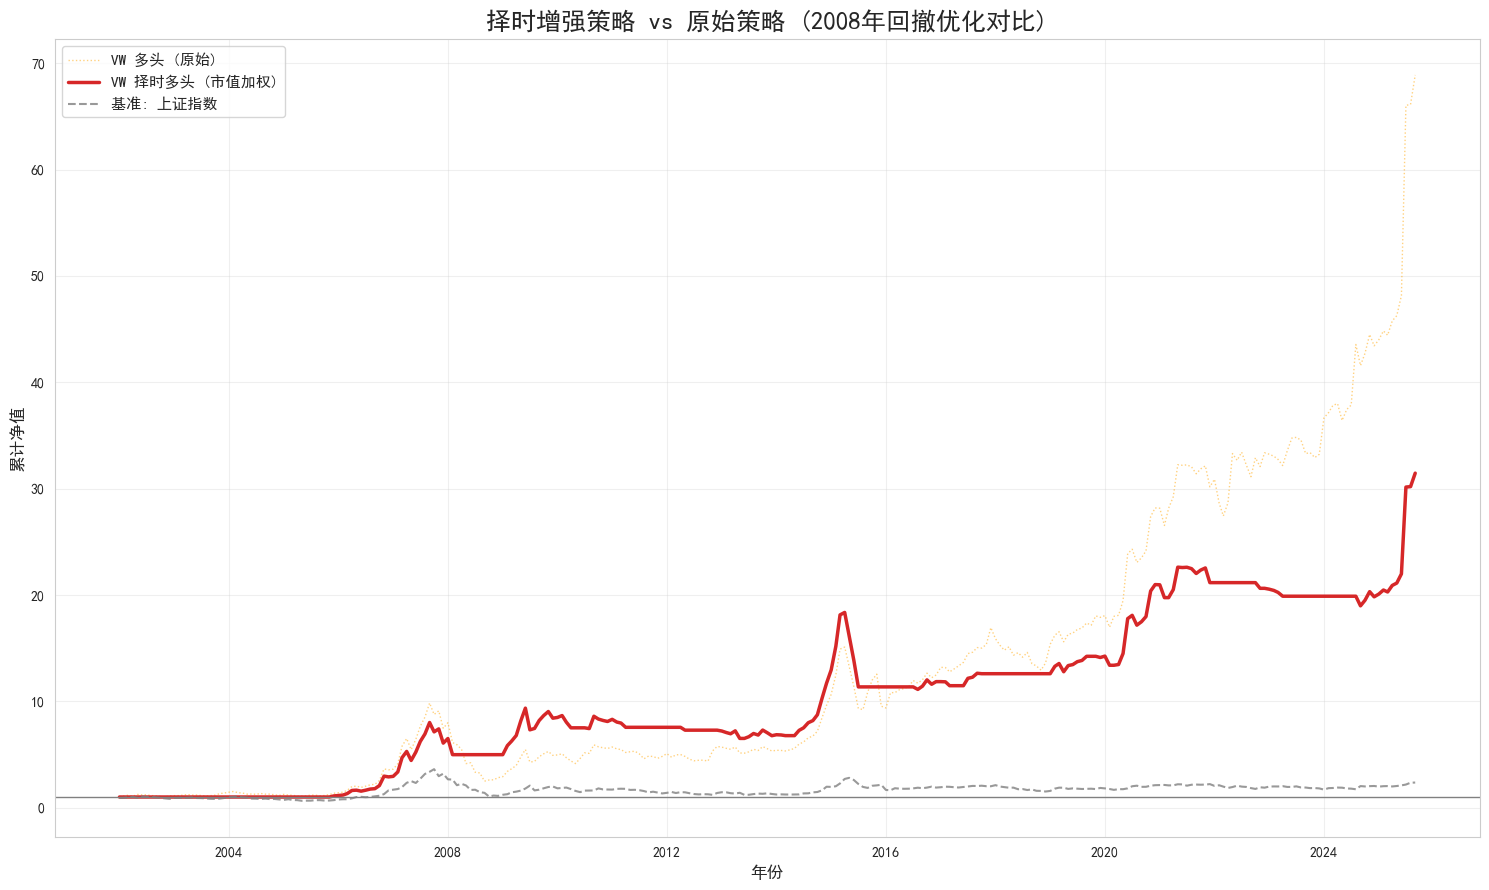

In [26]:
'''
# ==========================================
# 修改后的 Step 5: 包含择时策略的绘图
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 1. 计算累计净值
cum_performance = (1 + performance_df).cumprod()

# 2. 创建画布
plt.figure(figsize=(15, 9))

# --- A. 原始多头 (作为背景对比，用细线/透明色) ---
plt.plot(cum_performance.index, cum_performance['VW_Long'], 
         label='VW 多头 (原始)', color='orange', linewidth=1, alpha=0.5, linestyle=':')
'''
plt.plot(cum_performance.index, cum_performance['EW_Long'], 
         label='EW 多头 (原始)', color='lightgreen', linewidth=1, alpha=0.5, linestyle=':')
'''
# --- B. 择时多头 (重点展示，用实线/深色) ---
plt.plot(cum_performance.index, cum_performance['VW_Long_Timing'], 
         label='VW 择时多头 (市值加权)', color='#d62728', linewidth=2.5) # 深红
'''
plt.plot(cum_performance.index, cum_performance['EW_Long_Timing'], 
         label='EW 择时多头 (等权)', color='#2ca02c', linewidth=2.5) # 深绿
'''
# --- C. 市场基准 ---
if not cum_bench.empty:
    plt.plot(cum_bench.index, cum_bench['上证指数'], 
             label='基准: 上证指数', color='gray', linestyle='--', linewidth=1.5, alpha=0.8)

# 4. 修饰
plt.axhline(y=1, color='grey', linestyle='-', linewidth=1)
plt.title('择时增强策略 vs 原始策略 (2008年回撤优化对比)', fontsize=18, fontweight='bold')
plt.xlabel('年份', fontsize=12)
plt.ylabel('累计净值', fontsize=12)
plt.legend(fontsize=11, loc='upper left', frameon=True, fancybox=True)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
'''

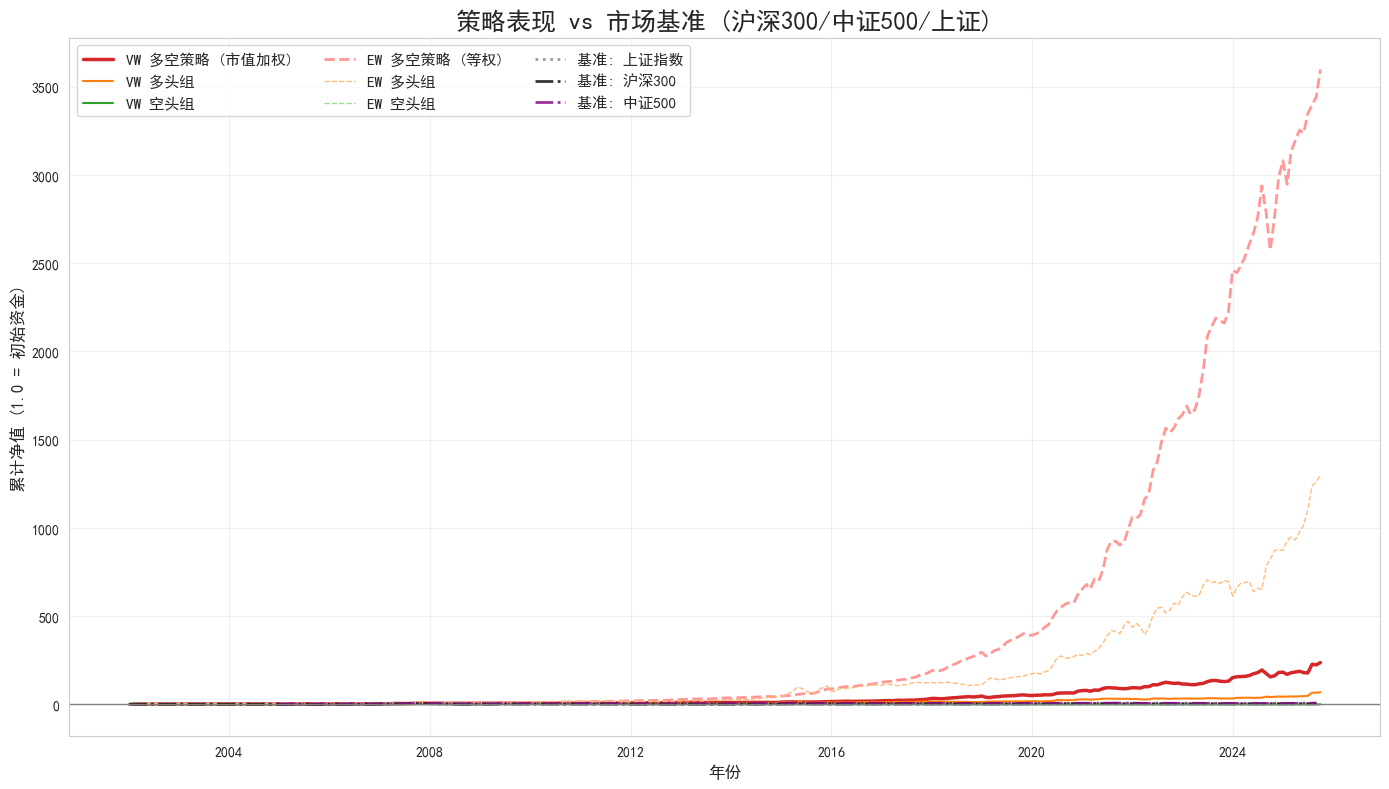

In [31]:

# ==========================================
# Step 5: 综合对比绘图 (EW vs VW)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 1. 计算累计净值
cum_performance = (1 + performance_df).cumprod()

# 2. 创建画布
plt.figure(figsize=(14, 8))

# --- 绘制市值加权 (VW) - 实线 ---
plt.plot(cum_performance.index, cum_performance['VW_Strategy'], 
         label='VW 多空策略 (市值加权)', color='#d62728', linewidth=2.5) # 深红
plt.plot(cum_performance.index, cum_performance['VW_Long'], 
         label='VW 多头组', color='#ff7f0e', linewidth=1.5) # 深橙
plt.plot(cum_performance.index, cum_performance['VW_Short'], 
         label='VW 空头组', color='#2ca02c', linewidth=1.5) # 深绿

# --- 绘制等权 (EW) - 虚线/透明度稍高 ---
# 既然都要在一张图，建议用同色系但不同线型来区分
plt.plot(cum_performance.index, cum_performance['EW_Strategy'], 
         label='EW 多空策略 (等权)', color='#ff9896', linestyle='--', linewidth=2) # 浅红
plt.plot(cum_performance.index, cum_performance['EW_Long'], 
         label='EW 多头组', color='#ffbb78', linestyle='--', linewidth=1) # 浅橙
plt.plot(cum_performance.index, cum_performance['EW_Short'], 
         label='EW 空头组', color='#98df8a', linestyle='--', linewidth=1) # 浅绿

# --- B. 绘制市场基准线 (新增部分) ---
if not cum_bench.empty:
    # 定义基准颜色和线型
    bench_styles = {
        '沪深300': {'color': 'black', 'linestyle': '-.'},
        '中证500': {'color': 'purple', 'linestyle': '-.'},
        '上证指数': {'color': 'gray', 'linestyle': ':'}
    }
    
    for col in cum_bench.columns:
        # 只画非空数据 (自动处理起始时间不同的问题)
        series = cum_bench[col].dropna()
        if not series.empty:
            style = bench_styles.get(col, {'color': 'blue', 'linestyle': '--'})
            plt.plot(series.index, series, 
                     label=f'基准: {col}', 
                     color=style['color'], 
                     linestyle=style['linestyle'], 
                     linewidth=2, 
                     alpha=0.8)

# 4. 辅助线和修饰
plt.axhline(y=1, color='grey', linestyle='-', linewidth=1)
plt.title('策略表现 vs 市场基准 (沪深300/中证500/上证)', fontsize=18, fontweight='bold')
plt.xlabel('年份', fontsize=12)
plt.ylabel('累计净值 (1.0 = 初始资金)', fontsize=12)

# 放置图例
plt.legend(fontsize=11, loc='upper left', ncol=3, frameon=True, fancybox=True)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()